In [1]:
import pandas as pd
import matplotlib.pyplot as plt 
import numpy as np
from scipy import stats
import statsmodels.api as sm
from statsmodels.tsa.seasonal import seasonal_decompose
import statsmodels

In [2]:
import urllib
params ='DRIVER={SQL Server};SERVER=CL-AMILAH\AMILA;DATABASE=GSH;UID=Amila;Trusted_Connection=yes;'       
params = urllib.parse.quote_plus(params)

from sqlalchemy import create_engine
db = create_engine('mssql+pyodbc:///?odbc_connect=%s' % params)

In [3]:
sql = '''
SELECT inv.[ID] ,inv.SiteUID, [Date] , [OutletUID] ,ot.Name AS outlet ,pr.Description AS province , di.Description AS district 
, ar.Description AS Area , inv.[AgentUID] ,Concat(emp.FirstName ,' ' , emp.MiddleInitials , ' ', emp.LastName ) AS AgentName , inv.[DistributorUID] , d.Name AS distributor, [ItemUID] ,it.Description AS item, [UnitQty] 
, [UnitPrice] , [RetailUnitPrice] , [FreeQty] , [FreeCompanyQty] , [GrossValue]
,datename(YEAR, Date) AS Year
,datename(month, Date) AS MonthName
,MONTH(Date) AS Month
,datename(DAY, Date) AS Day
,DATEPART(DW,Date) AS WeekDay
,datename(WEEKDAY, Date) AS DateName
,DATEPART (hh,Date) as Hour

  FROM [GSH].[dbo].[vw_Invoice] inv
  LEFT JOIN [GSH].[dbo].[vw_InvoiceLine] invl
  ON inv.siteUID = invl.TxnInvoice_SiteUID AND inv.uid = invl.TxnInvoiceUID	
  LEFT JOIN [GSH].[dbo].[Item] it
  ON invl.ItemUID = it.UID
  LEFT JOIN [GSH].[dbo].[Outlet] ot
  ON inv.OutletUID = ot.UID
  LEFT JOIN [GSH].[dbo].[Area] pr
  ON ot.ProvinceUID = pr.UID
  LEFT JOIN [GSH].[dbo].[Area] di
  ON ot.DistrictUID = di.UID
  LEFT JOIN [GSH].[dbo].[Area] ar
  ON ot.AreaUID = ar.UID
  LEFT JOIN [GSH].[dbo].[Distributor] d
  ON inv.DistributorUID = d.UID
  LEFT JOIN [GSH].[dbo].[avLogin] avlg
  ON inv.AgentUID = avlg.BusinessUserUID
  LEFT JOIN [GSH].[dbo].[Employee] emp
  ON avlg.EmployeeUID = emp.UID
  WHERE inv.mpt_TypeEnum IN ( 21 , 44, 14, 1) AND inv.ExpiryDate IS NULL AND inv.SubmittedDate IS NOT NULL
  AND Date >= '2018-11-01' AND Date <= '2020-03-01' ;
'''

invoice_All = pd.read_sql_query(sql, db)

In [4]:
#disply all the columns
pd.set_option('display.max_columns', None)

In [5]:
invoice_All.head()

,ID,SiteUID,Date,OutletUID,outlet,province,district,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
0,CSO011801117,55,2018-11-02 07:56:14.343,283,SUPREME PHARMACY,Western Province,Gampaha,Negombo,118,,2,The West Central Pharma (Pvt) Ltd.,341,Major-II Blood Glucose Test Strips-25's,2.0,1010.00,1160.0,0.0,0.0,2020.0,2018,November,11,2,6,Friday,7
1,CSO009101064,113,2018-11-02 10:52:04.427,3557,Wimalasiri Pharmacy,Southern Province,Galle,Batapola,91,Sasanga Nawod,8,Kalyani Pharmacy,56,GLUCOTRUST 500mg (10X10),10.0,175.44,200.0,0.0,0.0,1754.4,2018,November,11,2,6,Friday,10
2,CSO009101064,113,2018-11-02 10:52:04.427,3557,Wimalasiri Pharmacy,Southern Province,Galle,Batapola,91,Sasanga Nawod,8,Kalyani Pharmacy,56,GLUCOTRUST 500mg (10X10),0.0,175.44,200.0,1.0,1.0,0.0,2018,November,11,2,6,Friday,10
3,IN0066000101,0,2018-11-02 08:59:44.727,2639,Aruna Pharmacy,Southern Province,Matara,Matara,155,Priyashantha Niyagamage,14,Unichemist Distributor,125,Fusiway H-15g-1's,3.0,282.70,325.0,0.0,0.0,848.1,2018,November,11,2,6,Friday,8
4,CSO008001483,56,2018-11-02 15:58:07.127,289,SILVER RAY PHARMACY,Western Province,Gampaha,Negombo,80,Sithum Asela,2,The West Central Pharma (Pvt) Ltd.,189,Fastaid Gel 1.16% 20 g,10.0,67.60,77.0,0.0,0.0,676.0,2018,November,11,2,6,Friday,15


### Select the most selling product to identify the time series prediction

In [6]:
# select product sales records 
#Belcid Suspension 240ml top 1 product
Pro1_invoice_All = invoice_All.loc[invoice_All['ItemUID'] == 43]

In [7]:
Pro1_invoice_All.head()

,ID,SiteUID,Date,OutletUID,outlet,province,district,Area,AgentUID,AgentName,DistributorUID,distributor,ItemUID,item,UnitQty,UnitPrice,RetailUnitPrice,FreeQty,FreeCompanyQty,GrossValue,Year,MonthName,Month,Day,WeekDay,DateName,Hour
1240,IN0066000103,0,2018-11-02 12:05:39.753,2693,Sethsuwa Pharmacy,Southern Province,Hambantota,Angunukolapelessa,155,Priyashantha Niyagamage,14,Unichemist Distributor,43,Losatrust 50mg 100's,3.0,276.3,315.0,0.0,0.0,828.9,2018,November,11,2,6,Friday,12
1262,CSO009101074,113,2018-11-03 11:11:12.093,1561,Tharushi Pharmacy,Western Province,Kalutara,Bandaragama,91,Sasanga Nawod,8,Kalyani Pharmacy,43,Losatrust 50mg 100's,50.0,276.3,315.0,0.0,0.0,13815.0,2018,November,11,3,7,Saturday,11
1263,CSO009101074,113,2018-11-03 11:11:12.093,1561,Tharushi Pharmacy,Western Province,Kalutara,Bandaragama,91,Sasanga Nawod,8,Kalyani Pharmacy,43,Losatrust 50mg 100's,0.0,276.3,315.0,10.0,10.0,0.0,2018,November,11,3,7,Saturday,11
1982,CSO009101068,113,2018-11-02 16:46:55.527,1712,Saranga Pharmacy,Southern Province,Galle,Hikkaduwa,91,Sasanga Nawod,8,Kalyani Pharmacy,43,Losatrust 50mg 100's,50.0,276.3,315.0,0.0,0.0,13815.0,2018,November,11,2,6,Friday,16
1983,CSO009101068,113,2018-11-02 16:46:55.527,1712,Saranga Pharmacy,Southern Province,Galle,Hikkaduwa,91,Sasanga Nawod,8,Kalyani Pharmacy,43,Losatrust 50mg 100's,0.0,276.3,315.0,10.0,10.0,0.0,2018,November,11,2,6,Friday,16


In [8]:
 #get date from date time
Pro1_invoice_All['just_date'] = Pro1_invoice_All['Date'].dt.date

<ipython-input-8-dd577f3fd3f2>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  Pro1_invoice_All['just_date'] = Pro1_invoice_All['Date'].dt.date


In [9]:
Pro1_inv_grp = Pro1_invoice_All.groupby("just_date").agg({'GrossValue':'sum'}).reset_index()

In [10]:
Pro1_inv_grp 

,just_date,GrossValue
0,2018-11-01,11052.0
1,2018-11-02,75429.9
2,2018-11-03,474130.8
3,2018-11-05,92007.9
4,2018-11-06,227947.5
...,...,...
416,2020-02-25,351499.0
417,2020-02-26,335849.0
418,2020-02-27,317695.0
419,2020-02-28,332719.0


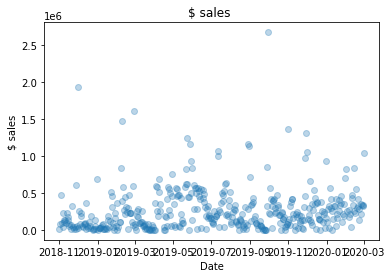

In [11]:
plt.scatter(Pro1_inv_grp.just_date , Pro1_inv_grp.GrossValue , alpha=0.3,cmap='viridis')
plt.xlabel("Date")
plt.ylabel("$ sales")
plt.title("$ sales ")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

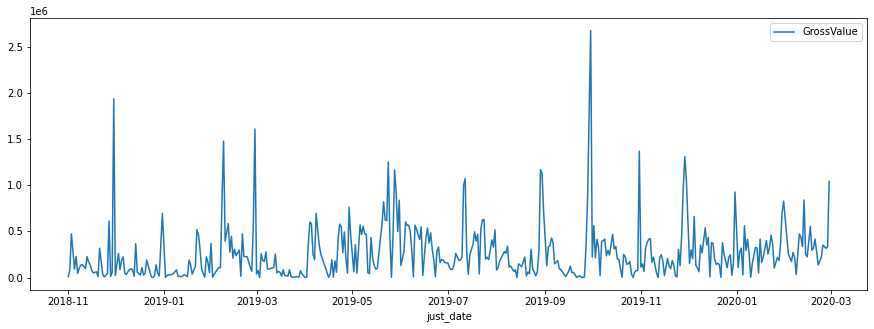

In [12]:
Pro1_inv_grp.plot(kind = 'line', x = 'just_date', y = 'GrossValue')
plt.show()

In [13]:
# remove z score > 3 
Pro1_inv_grp = Pro1_inv_grp[(np.abs(stats.zscore(Pro1_inv_grp["GrossValue"])) < 3)]

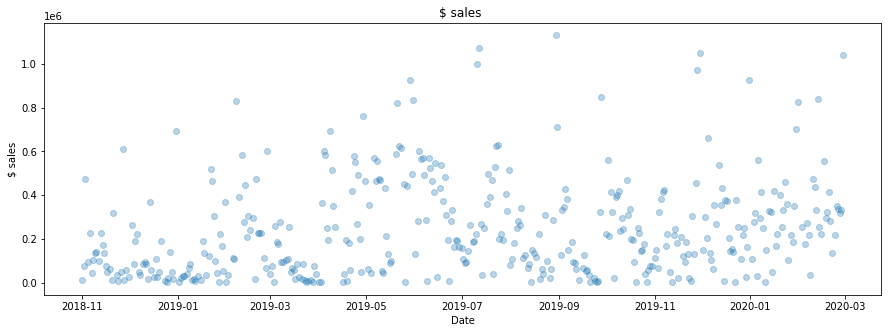

In [14]:
plt.scatter(Pro1_inv_grp.just_date , Pro1_inv_grp.GrossValue , alpha=0.3,cmap='viridis')
plt.xlabel("Date")
plt.ylabel("$ sales")
plt.title("$ sales ")
plt.rcParams['figure.figsize'] = [15, 5]
plt.show()

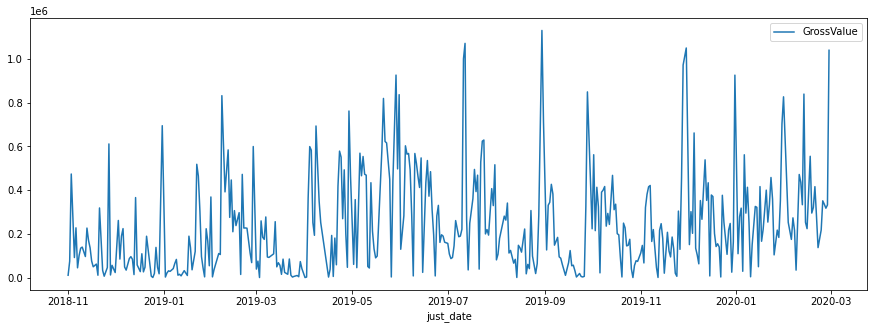

In [15]:
Pro1_inv_grp.plot(kind = 'line', x = 'just_date', y = 'GrossValue')
plt.show()

In [16]:
 #fill in the missing dates
drange = pd.date_range(start=Pro1_inv_grp.just_date.min(), end=Pro1_inv_grp.just_date.max())
Pro1_inv_grp = Pro1_inv_grp.set_index('just_date').reindex(drange).rename_axis('just_date').reset_index()

In [17]:
#fill missing value with mean
Pro1_inv_grp.fillna({"GrossValue":Pro1_inv_grp['GrossValue'].mean().round(1)}, inplace=True)

In [18]:
Pro1_inv_grp = Pro1_inv_grp.sort_index()
Pro1_inv_grp.head(50)

,just_date,GrossValue
0,2018-11-01,11052.00
1,2018-11-02,75429.90
2,2018-11-03,474130.80
3,2018-11-04,241395.80
4,2018-11-05,92007.90
5,2018-11-06,227947.50
6,2018-11-07,45036.90
7,2018-11-08,101125.80
8,2018-11-09,134834.40
9,2018-11-10,139807.80


In [19]:
#Pro1_inv_Nor_Sm = Pro1_inv_Nor_Sm.reset_index()
train = Pro1_inv_grp.loc[Pro1_inv_grp['just_date'] <= "2019-11-30"]
train = train.set_index('just_date')
test = Pro1_inv_grp.loc[Pro1_inv_grp['just_date'] > "2019-11-30"]
test = test.set_index('just_date')

In [20]:
from pmdarima import auto_arima
model = auto_arima(train.GrossValue, test='adf', trace=True)
results = model.fit(train.GrossValue)
results.summary()

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=10724.542, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=10783.311, Time=0.00 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=10724.590, Time=0.02 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=10742.314, Time=0.04 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=11104.531, Time=0.01 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=10723.511, Time=0.06 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=10726.747, Time=0.05 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=10723.197, Time=0.05 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=10723.086, Time=0.06 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=10721.098, Time=0.04 sec
 ARIMA(3,0,0)(0,0,0)[0] intercept   : AIC=10723.067, Time=0.06 sec
 ARIMA(3,0,1)(0,0,0)[0] intercept   : AIC=10725.065, Time=0.12 sec
 ARIMA(2,0,0)(0,0,0)[0]             : AIC=10776.308, Time=0.03 sec

Best model:  ARIMA(2,0,0)(0,0,0)[0] intercept
Total fit time: 0.704 seconds


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:                      y   No. Observations:                  395
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -5356.549
Date:                Thu, 17 Mar 2022   AIC                          10721.098
Time:                        19:14:45   BIC                          10737.013
Sample:                             0   HQIC                         10727.403
                                - 395                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
intercept    1.26e+05   1.68e+04      7.486      0.000     9.3e+04    1.59e+05
ar.L1          0.3374      0.042      8.026      0.000       0.255       0.420
ar.L2          0.1184      0.039      3.067      0.002       0.043       0.194
sigma2      3.523e+10      0.073   4.81e+11      0.000    3.52e+10    3.52e+10
===================================================================================
Ljung-Box (L1) (Q):                   0.00   Jarque-Bera (JB):               287.13
Prob(Q):                              0.96   Prob(JB):                         0.00
Heteroskedasticity (H):               1.29   Skew:                             1.40
Prob(H) (two-sided):                  0.15   Kurtosis:                         6.10
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 3.27e+26. Standard errors may be unstable.
"""

In [21]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
model = SARIMAX(train['GrossValue'],
                order=(2,0,0),seasonal_order=(0,0,0,0))
results = model.fit(disp=0)
results.summary()

c:\users\amila.h\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'
c:\users\amila.h\appdata\local\programs\python\python39\lib\site-packages\statsmodels\tsa\base\tsa_model.py:536: ValueWarning: No frequency information was provided, so inferred frequency D will be used.
  warnings.warn('No frequency information was'


<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:             GrossValue   No. Observations:                  395
Model:               SARIMAX(2, 0, 0)   Log Likelihood               -5385.154
Date:                Thu, 17 Mar 2022   AIC                          10776.308
Time:                        19:14:45   BIC                          10788.244
Sample:                    11-01-2018   HQIC                         10781.037
                         - 11-30-2019                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.5177      0.040     12.992      0.000       0.440       0.596
ar.L2          0.2984      0.039      7.724      0.000       0.223       0.374
sigma2      4.076e+10   4.89e-14   8.34e+23      0.000    4.08e+10    4.08e+10
===================================================================================
Ljung-Box (L1) (Q):                   3.08   Jarque-Bera (JB):               160.22
Prob(Q):                              0.08   Prob(JB):                         0.00
Heteroskedasticity (H):               1.27   Skew:                             0.87
Prob(H) (two-sided):                  0.17   Kurtosis:                         5.58
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
[2] Covariance matrix is singular or near-singular, with condition number 7.46e+39. Standard errors may be unstable.
"""

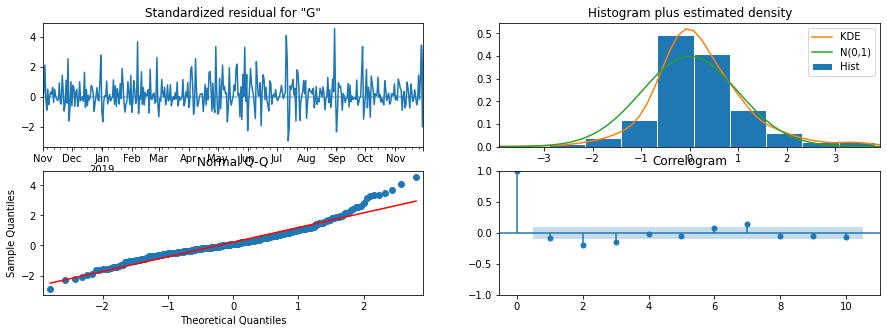

In [22]:
results.plot_diagnostics()
plt.show()

### Rolling Forecast ARIMA Model

In [23]:
X = Pro1_inv_grp.GrossValue.values
data_Size = int(len(Pro1_inv_grp.GrossValue.values))
train_size = int(len(train.GrossValue.values))


train, test = X[0:train_size], X[train_size:data_Size]
history = [x for x in train]
predictions = []

In [24]:
for t in range(len(test)):
    model = SARIMAX(history, order=(2,0,0),seasonal_order=(0,0,0,0))
    model_fit = model.fit(disp=0)
    output = model_fit.forecast()
    yhat = output[0]
    predictions.append(yhat)
    obs = test[t]
    history.append(obs)
    print('predicted=%f, expected=%f' % (yhat, obs))

predicted=615922.718016, expected=241395.800000
predicted=445832.276962, expected=151179.000000
predicted=148031.923638, expected=302045.000000
predicted=198111.467507, expected=202824.000000
predicted=192469.104290, expected=661995.000000
predicted=396663.360507, expected=134590.000000
predicted=268771.477441, expected=103603.000000
predicted=92381.942678, expected=63226.000000
predicted=62793.250499, expected=352751.000000
predicted=196292.546037, expected=266989.000000
predicted=240133.411710, expected=241395.800000
predicted=201566.570902, expected=538986.000000
predicted=344722.149332, expected=353377.000000
predicted=340669.339499, expected=434077.000000
predicted=325964.184812, expected=7825.000000
predicted=134924.707522, expected=378104.000000
predicted=190580.740306, expected=370905.000000
predicted=301167.656460, expected=201885.000000
predicted=213935.165441, expected=142415.000000
predicted=132598.930432, expected=154935.000000
predicted=120846.048121, expected=139911.0000

In [25]:
from sklearn.metrics import mean_squared_error
from math import sqrt
mse = mean_squared_error(test, predictions)
rmse = sqrt(mse)
print('RMSE: %f' % rmse)

RMSE: 229048.834020


#### Since this is quiet high value for RMSE the model is not best to predict.

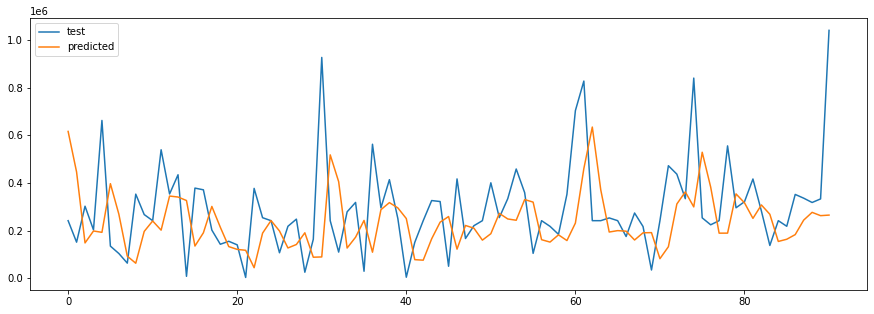

In [26]:
plt.plot(test)
plt.plot(predictions)
plt.legend(['test', 'predicted'])